In [1]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

import matplotlib.pyplot as plt
import tensorflow as tf
# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

import pyaudio
import wave
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [2]:
learning_rate = 0.01
seq_length = 9 #layer
# train Parameters
X_dim = 442 #n_dim #X_hot.shape[2]

#seq_length = 7 #X_hot.shape[1]
output_dim = 1 #n_classes #Y_hot.shape[1]

hidden_dim = 2
learning_rate = 0.05

In [3]:
# input place holders
X = tf.placeholder(tf.float32, [None, seq_length, X_dim], name = 'X')
Y = tf.placeholder(tf.float32, [None, output_dim], name = 'Y')


# build a LSTM network
cell = tf.contrib.rnn.BasicLSTMCell(
    num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

Y_pred = tf.contrib.layers.fully_connected(
    outputs[:, -1], output_dim, activation_fn=None)  # We use the last cell's output

# cost/loss
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
#loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Y_pred, labels = Y))

# optimizer
lr = tf.placeholder(tf.float32,shape=(), name='learning_rate')
train = tf.train.AdamOptimizer(lr).minimize(loss) #AdamOptimizer

# RMSE
targets = tf.placeholder(tf.float32, [None, output_dim] , name = 'targets')
predictions = tf.placeholder(tf.float32, [None, output_dim] , name = 'predictions')
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))


In [4]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)
def showFreqTime(combine):
    for sample, filename, _ in combine:
        freqs, times, spectrogram = log_specgram(sample, SR)
        fig = plt.figure(figsize=(14, 10))
        ax1 = fig.add_subplot(211)
        ax1.set_title('Raw wave of ' + filename)
        ax1.set_ylabel('Amplitude')
        ax1.plot(np.linspace(0, len(sample)/SR, len(sample)), sample)

        ax2 = fig.add_subplot(212)
        ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
               extent=[times.min(), times.max(), freqs.min(), freqs.max()])
        ax2.set_yticks(freqs[::16])
        ax2.set_xticks(times[::16])
        ax2.set_title('Spectrogram of ' + filename)
        ax2.set_ylabel('Freqs in Hz')
        ax2.set_xlabel('Seconds')

INFO:tensorflow:Restoring parameters from ../models/RNN/my_RNN_model_S9_40


c:\users\jh\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\client\session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


(884736,)
[[0.96526194]
 [0.9930773 ]
 [1.0788713 ]
 [1.0774707 ]
 [1.0773492 ]
 [1.0800405 ]
 [1.0292526 ]
 [1.0770136 ]
 [1.07177   ]
 [1.0776527 ]]
F-Score: 0.829
Accuracy:  0.829243865798698
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00         0
        1.0       1.00      0.83      0.91      1997

avg / total       1.00      0.83      0.91      1997

[[   0    0]
 [ 341 1656]]


c:\users\jh\anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


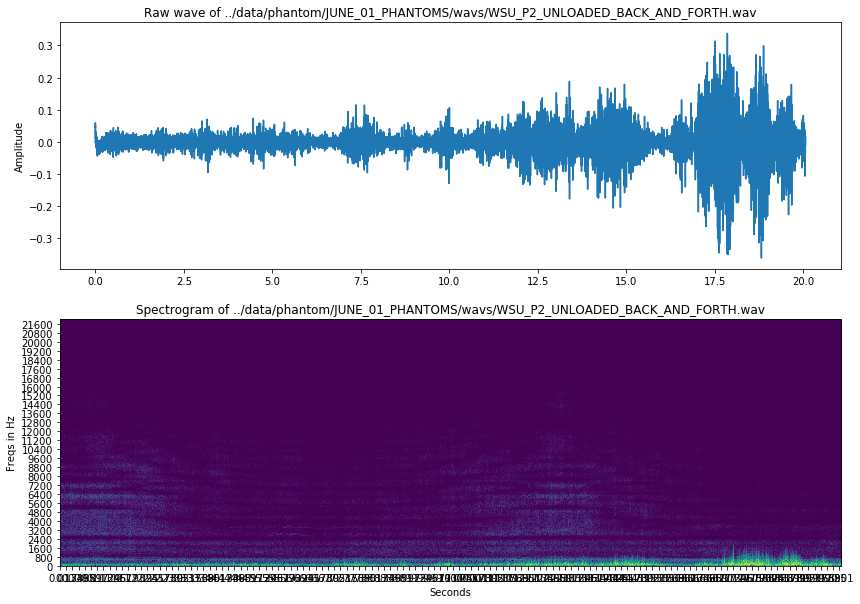

In [9]:
model_path_f = '../models/RNN/'
filename = 'my_RNN_model_S9_40'


sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.restore(sess, model_path_f+filename)

SR = 44100
####
justone = True

mean = np.load('../data/Xy/RNN_mean.npy')
std = np.load('../data/Xy/RNN_std.npy')

while(justone):
    justone = False
    #print("start to record the audio.")
    '''
    frames = []
    for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK)
        frames.append(data)
    #print("Recording finished.")
    stream.stop_stream()
    stream.close()

    p.terminate()

    wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(b''.join(frames))
    wf.close()
    '''
    ####
    filename1 = '../data/phantom/JUNE_01_PHANTOMS/wavs/WSU_P2_UNLOADED_BACK_AND_FORTH.wav'
    filename2 = '../data/phantom/JUNE_02_BACKGROUND/wavs/background/canopy_heavy_wind.wav'
    
    sample, sample_rate = librosa.load(filename1,SR)
    print(sample.shape)
    
    
    freqs, times, spectrogram = log_specgram(sample, sample_rate)  
    showFreqTime([[sample, filename1, SR]])  

    spectrogram = (spectrogram - mean) / std
    
    dataX = spectrogram
    #print(dataX.shape)
    #print('delta shape:',dataX.shape)

    X_hot_list= []
    #print(dataX.shape[0] - seq_length+1)
    for i in range(0, dataX.shape[0] - seq_length+1):
        _x = dataX[i:i + seq_length]
        X_hot_list.append(_x)
    X_hot = np.array(X_hot_list[:])
    #print(X_hot[0])
    #print('\n\n\n')
    y_pred = sess.run(Y_pred,feed_dict={X: X_hot})
    #y_pred[y_pred<0.5] = 0
    #y_pred[y_pred>=0.5] = 1
    print(y_pred[20:30] )
    y_true = np.ones(shape=[y_pred.shape[0]])
    y_pred[y_pred<0.5] = 0
    y_pred[y_pred>=0.5] = 1
    
    p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
    print("F-Score:", round(f,3))
    print("Accuracy: ", accuracy_score(y_true, y_pred))

    print(classification_report(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred))

    '''
    if y_pred[0] == 1:
        print('The sound is Drone')
    else :
        print('THe sound isn\'t Drone')
    '''

sess.close()